# Topic Model & Subjects

In [1]:
# Import necessary libraries.
import re, nltk, warnings, csv, sys, os, pickle, string
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain
from scipy import stats
import matplotlib.pyplot as plt

# Import NLTK packages.
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Import sklearn packages.
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# Import and append stopwords.
stop_words = stopwords.words("english")
stop_words.append('mr')

# Ignore warnings related to deprecated functions.
warnings.simplefilter("ignore", DeprecationWarning)

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/"

# Read in file; select columns; drop rows with NA values (entries without a named person).
df = pd.read_csv(abs_dir + 'Data/Output/ParsedXML/JQA_Subjects-dataframe.txt',
                 sep = '\t') \
    .dropna()

df.head()

,file,entry,date,subject,text
0,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-01,1817-10-01,"Adams Family Residences,Commerce",1. IV:30. Wednesday. Wrote a Letter to J. L. S...
1,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-02,1817-10-02,"Foreign Relations,Health and Illness,South Ame...",2. IV: Continued drafting instructions for Rus...
2,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-03,1817-10-03,"Adams Family Residences,Privateering,Recreatio...",3. IV: I had visits this morning from Mr Levet...
3,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-04,1817-10-04,"Commerce,Foreign Relations,Health and Illness",4. IV: I waked before three and had afterwards...
4,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-05,1817-10-05,Adams Family Residences,5. V: The Ladies went this morning to St. John...


## Clean & Prepare Data

In [2]:
%%time

# # Unnest subject headings. 
# df['subject'] = df['subject'].str.split(',')
# df = df.explode('subject')
# print ('Number of unique subject headings:', len(df['subject'].unique()), '\n')

# Lowercase text field
df['text'] = df['text'].str.lower()

# Tokenize text field.
df['text'] = df['text'].apply(word_tokenize)

# Lemmatize and stem text field.
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english", ignore_stopwords = True)

def lemma_and_stem(list_of_words):
    return [stemmer.stem(lemmatizer.lemmatize(w)) for w in list_of_words if w not in stop_words]

df['text'] = df['text'].apply(lemma_and_stem)

# Convert list of words to string for LDA model.
df['text'] = df['text'].apply(' '.join)

# Light regex cleanup to remove JQA's initial numbering (&, eventually, roman numeral sequencing).
df['text'] = df['text'].str.replace(r'^\d+.', '', regex = True)

df.head()

CPU times: user 15.5 s, sys: 133 ms, total: 15.6 s
Wall time: 15.8 s


,file,entry,date,subject,text
0,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-01,1817-10-01,"Adams Family Residences,Commerce",iv:30. wednesday . wrote letter j. l. sulliva...
1,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-02,1817-10-02,"Foreign Relations,Health and Illness,South Ame...",iv : continu draft instruct rush . subject op...
2,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-03,1817-10-03,"Adams Family Residences,Privateering,Recreatio...","iv : visit morn levett harri , nours regist t..."
3,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-04,1817-10-04,"Commerce,Foreign Relations,Health and Illness",iv : wake three afterward sleep . inconveni n...
4,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-05,1817-10-05,Adams Family Residences,v : ladi went morn st. john ’ church ; return...


### Average Document Length

CPU times: user 76.7 ms, sys: 2.93 ms, total: 79.6 ms
Wall time: 78.7 ms


Text(310.7010421189753, 1006.4250000000001, 'Mean: 282.46')

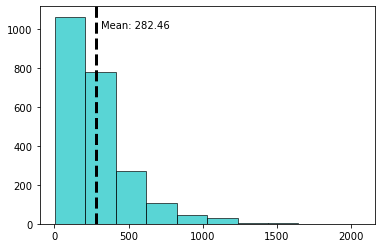

In [3]:
%%time

# Drop duplicate texts (created from unnested subject headings) & count words.
doc_len = df['text'].str.split(' ').str.len() \
    .reset_index() \
    .drop_duplicates()

doc_len = pd.DataFrame(doc_len)

x = doc_len['text']

# Plot graph.
ax = plt.hist(x, bins = 10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color = 'k', linestyle = 'dashed', linewidth = 3)

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))

### Normalize Document Length

In [4]:
%%time

def splitText(string):
    words = string.split()
    grouped_words = [' '.join(words[i: i + 200]) for i in range(0, len(words), 200)]
    return grouped_words

df['text'] = df['text'].apply(splitText)

df = df.explode('text')

# Count words and remove short strings.
df['count'] = df['text'].str.split().str.len()
df = df[~(df['count'] < 50)]

df['cid'] = df.index

print (f'New Average Length of Docs: {df["count"].mean()}')
df.head(4)

New Average Length of Docs: 163.92192733831487
CPU times: user 124 ms, sys: 2.73 ms, total: 127 ms
Wall time: 126 ms


,file,entry,date,subject,text,count,cid
0,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-01,1817-10-01,"Adams Family Residences,Commerce",iv:30. wednesday . wrote letter j. l. sullivan...,148,0
1,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-02,1817-10-02,"Foreign Relations,Health and Illness,South Ame...",iv : continu draft instruct rush . subject ope...,200,1
2,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-03,1817-10-03,"Adams Family Residences,Privateering,Recreatio...","iv : visit morn levett harri , nours regist tr...",200,2
3,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-04,1817-10-04,"Commerce,Foreign Relations,Health and Illness",iv : wake three afterward sleep . inconveni ne...,200,3


## Train Topic Model

In [5]:
%%time

# Remove duplicate text rows (caused from unnesting headings) by subsetting & de-duplicating.
topics = df[['cid', 'text']]

# Initialise the vectorizer with English stop words.
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed texts.
features = vectorizer.fit_transform(topics['text'])

# Helper function (from Kapadia).
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Set parameters (topics set to number of unique subject headings found).
number_topics = 20
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components = number_topics, n_jobs=-1)
lda.fit(features)

CPU times: user 1.34 s, sys: 614 ms, total: 1.95 s
Wall time: 7.79 s


LatentDirichletAllocation(n_components=20, n_jobs=-1)

In [6]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
said govern presid state letter british told vessel offic receiv

Topic #1:
socrat decatur barron protagora fisk appropri sophist contract differ minist

Topic #2:
said commission year told letter came day barclay canning new

Topic #3:
vessel case court slave presid right captur search pirat law

Topic #4:
claim articl commission allow astronom treati year loss hassler state

Topic #5:
mr came letter offic presid day adam morn receiv return

Topic #6:
said told presid crawford new hous elect member friend vote

Topic #7:
mr south presid minist say came obtain american crawford receiv

Topic #8:
presid letter said told offic state came paper calhoun appoint

Topic #9:
spain treati presid oni note said govern told state spanish

Topic #10:
said great thought govern told thing presid man britain make

Topic #11:
letter day presid receiv russel offic written morn answer write

Topic #12:
day hour mr morn boat came went return hous adam

Topic #13:
state co

## Examine Patterns & Correlations

In [7]:
%%time

# Create a document-topic matrix.
dtm = lda.transform(features)

# Convert document-topic matrix to dataframe.
dtm = pd.DataFrame(dtm, index = topics.index)

# Join document-topic dataframe with metadata on shared indices.
dtm = pd.merge(df[['file', 'entry', 'date', 'subject']],
               dtm,
               left_index = True, right_index = True)

CPU times: user 21.1 ms, sys: 6.36 ms, total: 27.4 ms
Wall time: 457 ms


Measure of topic correlations when grouped by subject heading.

* Do topics correlate within a relation of subjects?

CPU times: user 1.61 s, sys: 16.8 ms, total: 1.62 s
Wall time: 356 ms


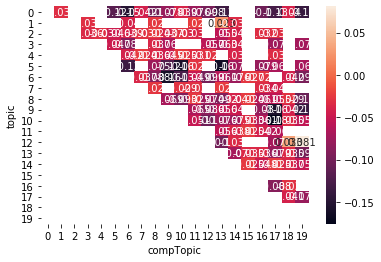

In [28]:
%%time

# Subset by column range.
subject_dtm = dtm.iloc[:, 3:]

# Split & explode subject headings.
subject_dtm['subject'] = subject_dtm['subject'].str.split(',')
subject_dtm = subject_dtm.explode('subject')

# Groupby subjects and average topics.
subject_dtm = subject_dtm.groupby(['subject']).mean()

# Measure correlations.
s_dtm_corr = pd.DataFrame()
s_dtm_pValues = pd.DataFrame()

# For each column in subject_dtm, measure correlation with other columns.
for x in subject_dtm.columns:
    for y in subject_dtm.columns:
        corr = stats.pearsonr(dtm[x], dtm[y])
        
#         Append results to dataframe at x-row, y-column.
        s_dtm_corr.loc[x, y] = corr[0]
        s_dtm_pValues.loc[x, y] = corr[1]

# Gather p-values into long dataframe and filter out insignificant results.
s_dtm_pValues['topic'] = s_dtm_pValues.index

s_dtm_pValues = pd.melt(s_dtm_pValues,
                        id_vars = ['topic'], var_name = 'compTopic')

s_dtm_pValues = s_dtm_pValues \
    .query('(topic != compTopic) & (value <= 0.025)')

# Gather correlations into dataframe and filter out insignificant results.
s_dtm_corr['topic'] = s_dtm_corr.index

s_dtm_corr = pd.melt(s_dtm_corr,
                     id_vars = ['topic'], var_name = 'compTopic', value_name = 'corr') \
    .query('(topic != compTopic)')

# Merge correlations and p-values in such a way to remove insignificant correlations/values.
s_dtm_corr = pd.merge(s_dtm_corr, s_dtm_pValues, on = ['topic', 'compTopic'], how = 'right')

# Convert dtm_corr dataframe to matrix for heatmap now that only the significant results remain.
s_dtm_corr = s_dtm_corr.pivot(index = 'topic', columns = 'compTopic', values = 'corr')

# Return upper triangle correlations.
# Lower triangle is redundant in symmetrical matrices.
s_dtm_corr = s_dtm_corr.where(np.triu(np.ones(s_dtm_corr.shape)).astype(np.bool))

# Plot heatmap of correlations.
ax = sns.heatmap(s_dtm_corr, annot = True)

There are no clear correlations between topics when grouped by subject headings.

## Clustering

In [29]:
%%time

dtm

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


,file,entry,date,subject,0,1,2,3,4,5,...,10,11,12,13,14,15,16,17,18,19
0,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-01,1817-10-01,"Adams Family Residences,Commerce",0.386625,0.000485,0.000485,0.000485,0.000485,0.579148,...,0.000485,0.000485,0.000485,0.000485,0.000485,0.000485,0.000485,0.000485,0.000485,0.000485
1,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-02,1817-10-02,"Foreign Relations,Health and Illness,South Ame...",0.287356,0.000309,0.000309,0.000309,0.000309,0.707089,...,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309
2,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-03,1817-10-03,"Adams Family Residences,Privateering,Recreatio...",0.194609,0.000347,0.000347,0.000347,0.000347,0.192754,...,0.156766,0.000347,0.007623,0.000347,0.000347,0.000347,0.000347,0.000347,0.000347,0.000347
3,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-04,1817-10-04,"Commerce,Foreign Relations,Health and Illness",0.000368,0.000368,0.000368,0.000368,0.000368,0.993015,...,0.000368,0.000368,0.000368,0.000368,0.000368,0.000368,0.000368,0.000368,0.000368,0.000368
4,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-05,1817-10-05,Adams Family Residences,0.000820,0.000820,0.000820,0.000820,0.000820,0.735497,...,0.000820,0.000820,0.089505,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820,0.139790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9113,JQADiaries-v31-1820-07-p381.xml,jqadiaries-v31-1820-07-30,1820-07-30,Religion,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,...,0.367841,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.311461
9113,JQADiaries-v31-1820-07-p381.xml,jqadiaries-v31-1820-07-30,1820-07-30,Religion,0.000305,0.000305,0.000305,0.000305,0.000305,0.000305,...,0.378591,0.596045,0.000305,0.000305,0.000305,0.000305,0.000305,0.000305,0.000305,0.020181
9113,JQADiaries-v31-1820-07-p381.xml,jqadiaries-v31-1820-07-30,1820-07-30,Religion,0.001163,0.001163,0.001163,0.001163,0.001163,0.001163,...,0.001163,0.705437,0.001163,0.001163,0.001163,0.001163,0.001163,0.001163,0.001163,0.273633
9114,JQADiaries-v31-1820-07-p381.xml,jqadiaries-v31-1820-07-31,1820-07-31,Privateering,0.616288,0.000526,0.000526,0.045856,0.000526,0.000526,...,0.000526,0.000526,0.198941,0.000526,0.130494,0.000526,0.000526,0.000526,0.000526,0.000526


## Network

A network graph can be visualized by measuring the "similarity" of one text's topics to another. 